<a href="https://colab.research.google.com/github/pradeepprasad/Machine_Learning_Workspace/blob/master/GridWorld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

------------------------------------------
-	-	-	-	-	-	-	-	-	

-	-	-	-	-	Bout	-	-	-	

Ain	-	-	-	-	-	-	-	-	

-	-	-	-	-	-	-	-	-	

-	-	-	-	-	-	-	-	-	

-	-	-	-	-	-	-	-	-	

Aout	-	-	-	-	-	-	-	-	

Bin	-	-	-	-	-	-	-	-	

-	-	-	-	-	-	-	-	-	

------------------------------------------
starting game  0
starting game  5000
starting game  10000
starting game  15000
starting game  20000
starting game  25000
starting game  30000
starting game  35000
starting game  40000
starting game  45000
------------------------------------------
-	-	-	-	-	-	-	-	-	

-	-	-	-	-	Bout	-	-	-	

Ain	-	-	-	-	-	-	-	-	

-	-	-	-	-	-	-	-	-	

-	-	-	-	-	-	-	-	-	

-	-	-	-	-	-	-	-	-	

-	-	-	-	-	-	-	-	-	

Bin	-	-	-	-	-	-	-	-	

-	-	-	-	-	-	-	-	X	

------------------------------------------


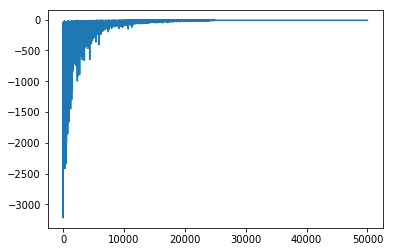

In [8]:
import numpy as np
import matplotlib.pyplot as plt

class GridWorld(object):
    def __init__(self, m, n, magicSquares):
        self.grid = np.zeros((m,n))
        self.m = m
        self.n = n
        self.stateSpace = [i for i in range(self.m*self.n)]
        self.stateSpace.remove(80)
        self.stateSpacePlus = [i for i in range(self.m*self.n)]
        self.actionSpace = {'U': -self.m, 'D': self.m,
                            'L': -1, 'R': 1}
        self.possibleActions = ['U', 'D', 'L', 'R']
        # dict with magic squares and resulting squares
        self.addMagicSquares(magicSquares)
        self.agentPosition = 0

    def isTerminalState(self, state):
        return state in self.stateSpacePlus and state not in self.stateSpace

    def addMagicSquares(self, magicSquares):
        self.magicSquares = magicSquares
        i = 2
        for square in self.magicSquares:
            x = square // self.m
            y = square % self.n
            self.grid[x][y] = i
            i += 1
            x = magicSquares[square] // self.m
            y = magicSquares[square] % self.n
            self.grid[x][y] = i
            i += 1

    def getAgentRowAndColumn(self):
        x = self.agentPosition // self.m
        y = self.agentPosition % self.n
        return x, y

    def setState(self, state):
        x, y = self.getAgentRowAndColumn()
        self.grid[x][y] = 0
        self.agentPosition = state
        x, y = self.getAgentRowAndColumn()
        self.grid[x][y] = 1

    def offGridMove(self, newState, oldState):
        # if we move into a row not in the grid
        if newState not in self.stateSpacePlus:
            return True
        # if we're trying to wrap around to next row
        elif oldState % self.m == 0 and newState  % self.m == self.m - 1:
            return True
        elif oldState % self.m == self.m - 1 and newState % self.m == 0:
            return True
        else:
            return False

    def step(self, action):
        agentX, agentY = self.getAgentRowAndColumn()
        resultingState = self.agentPosition + self.actionSpace[action]
        if resultingState in self.magicSquares.keys():
            resultingState = magicSquares[resultingState]

        reward = -1 if not self.isTerminalState(resultingState) else 0
        if not self.offGridMove(resultingState, self.agentPosition):
            self.setState(resultingState)
            return resultingState, reward, \
                   self.isTerminalState(resultingState), None
        else:
            return self.agentPosition, reward, \
                   self.isTerminalState(self.agentPosition), None

    def reset(self):
        self.agentPosition = 0
        self.grid = np.zeros((self.m,self.n))
        self.addMagicSquares(self.magicSquares)
        return self.agentPosition

    def render(self):
        print('------------------------------------------')
        for row in self.grid:
            for col in row:
                if col == 0:
                    print('-', end='\t')
                elif col == 1:
                    print('X', end='\t')
                elif col == 2:
                    print('Ain', end='\t')
                elif col == 3:
                    print('Aout', end='\t')
                elif col == 4:
                    print('Bin', end='\t')
                elif col == 5:
                    print('Bout', end='\t')
            print('\n')
        print('------------------------------------------')

    def actionSpaceSample(self):
        return np.random.choice(self.possibleActions)

def maxAction(Q, state, actions):
    values = np.array([Q[state,a] for a in actions])
    action = np.argmax(values)
    return actions[action]

if __name__ == '__main__':
    # map magic squares to their connecting square
    magicSquares = {18: 54, 63: 14}
    env = GridWorld(9, 9, magicSquares)
    # model hyperparameters
    ALPHA = 0.1
    GAMMA = 1.0
    EPS = 1.0
    #PP check the initia layout
    env.render()
    #PP ends
    Q = {}
    for state in env.stateSpacePlus:
        for action in env.possibleActions:
            Q[state, action] = 0

    numGames = 50000
    totalRewards = np.zeros(numGames)
    for i in range(numGames):
        if i % 5000 == 0:
            print('starting game ', i)
        done = False
        epRewards = 0
        observation = env.reset()
        while not done:
            rand = np.random.random()
            action = maxAction(Q,observation, env.possibleActions) if rand < (1-EPS) \
                                                    else env.actionSpaceSample()
            observation_, reward, done, info = env.step(action)
            epRewards += reward

            action_ = maxAction(Q, observation_, env.possibleActions)
            Q[observation,action] = Q[observation,action] + ALPHA*(reward + \
                        GAMMA*Q[observation_,action_] - Q[observation,action])
            observation = observation_
        if EPS - 2 / numGames > 0:
            EPS -= 2 / numGames
        else:
            EPS = 0
        totalRewards[i] = epRewards
    #PP check the finished game
    env.render()
    #PP ends
    plt.plot(totalRewards)
    plt.show()

0 1.0000 15.0
100 0.0995 11.0
200 0.0705 191.0
300 0.0576 119.0
400 0.0499 67.0
500 0.0447 42.0
600 0.0408 114.0
700 0.0378 36.0
800 0.0353 104.0
900 0.0333 144.0
1000 0.0316 149.0
1100 0.0301 131.0
1200 0.0289 126.0
1300 0.0277 139.0
1400 0.0267 138.0
1500 0.0258 110.0
1600 0.0250 128.0
1700 0.0242 121.0
1800 0.0236 113.0
1900 0.0229 131.0
2000 0.0224 132.0
2100 0.0218 133.0
2200 0.0213 115.0
2300 0.0208 110.0
2400 0.0204 94.0
2500 0.0200 169.0
2600 0.0196 181.0
2700 0.0192 154.0
2800 0.0189 178.0
2900 0.0186 170.0
3000 0.0183 163.0
3100 0.0180 176.0
3200 0.0177 152.0
3300 0.0174 161.0
3400 0.0171 136.0
3500 0.0169 173.0
3600 0.0167 131.0
3700 0.0164 128.0
3800 0.0162 150.0
3900 0.0160 138.0
4000 0.0158 137.0
4100 0.0156 172.0
4200 0.0154 168.0
4300 0.0152 155.0
4400 0.0151 178.0
4500 0.0149 153.0
4600 0.0147 174.0
4700 0.0146 165.0
4800 0.0144 182.0
4900 0.0143 128.0
5000 0.0141 137.0
5100 0.0140 111.0
5200 0.0139 162.0
5300 0.0137 78.0
5400 0.0136 143.0
5500 0.0135 188.0
5600 0.0134

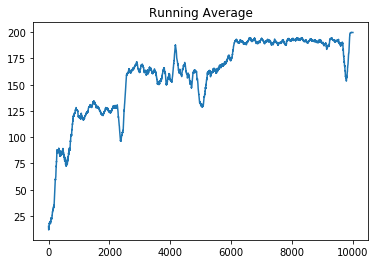

In [0]:
import gym
import numpy as np 
import matplotlib.pyplot as plt 

env = gym.make('CartPole-v0')

MAXSTATES = 10**4
GAMMA = 0.9
ALPHA = 0.01

def max_dict(d):
	max_v = float('-inf')
	for key, val in d.items():
		if val > max_v:
			max_v = val
			max_key = key
	return max_key, max_v

def create_bins():
	# obs[0] -> cart position --- -4.8 - 4.8
	# obs[1] -> cart velocity --- -inf - inf
	# obs[2] -> pole angle    --- -41.8 - 41.8
	# obs[3] -> pole velocity --- -inf - inf
	
	bins = np.zeros((4,10))
	bins[0] = np.linspace(-4.8, 4.8, 10)
	bins[1] = np.linspace(-5, 5, 10)
	bins[2] = np.linspace(-.418, .418, 10)
	bins[3] = np.linspace(-5, 5, 10)

	return bins

def assign_bins(observation, bins):
	state = np.zeros(4)
	for i in range(4):
		state[i] = np.digitize(observation[i], bins[i])
	return state

def get_state_as_string(state):
	string_state = ''.join(str(int(e)) for e in state)
	return string_state

def get_all_states_as_string():
	states = []
	for i in range(MAXSTATES):
		states.append(str(i).zfill(4))
	return states

def initialize_Q():
	Q = {}

	all_states = get_all_states_as_string()
	for state in all_states:
		Q[state] = {}
		for action in range(env.action_space.n):
			Q[state][action] = 0
	return Q

def play_one_game(bins, Q, eps=0.5):
	observation = env.reset()
	done = False
	cnt = 0 # number of moves in an episode
	state = get_state_as_string(assign_bins(observation, bins))
	total_reward = 0

	while not done:
		cnt += 1	
		# np.random.randn() seems to yield a random action 50% of the time ?
		if np.random.uniform() < eps:
			act = env.action_space.sample() # epsilon greedy
		else:			
			act = max_dict(Q[state])[0]
		
		observation, reward, done, _ = env.step(act)

		total_reward += reward

		if done and cnt < 200:
			reward = -300

		state_new = get_state_as_string(assign_bins(observation, bins))

		a1, max_q_s1a1 = max_dict(Q[state_new])
		Q[state][act] += ALPHA*(reward + GAMMA*max_q_s1a1 - Q[state][act])
		state, act = state_new, a1					

	return total_reward, cnt

def play_many_games(bins, N=10000):
	Q = initialize_Q()

	length = []
	reward = []
	for n in range(N):
		#eps=0.5/(1+n*10e-3)
		eps = 1.0 / np.sqrt(n+1)

		episode_reward, episode_length = play_one_game(bins, Q, eps)
		
		if n % 100 == 0:
			print(n, '%.4f' % eps, episode_reward)
		length.append(episode_length)
		reward.append(episode_reward)

	return length, reward

def plot_running_avg(totalrewards):
	N = len(totalrewards)
	running_avg = np.empty(N)
	for t in range(N):
		running_avg[t] = np.mean(totalrewards[max(0, t-100):(t+1)])
	plt.plot(running_avg)
	plt.title("Running Average")
	plt.show()

if __name__ == '__main__':
	bins = create_bins()
	episode_lengths, episode_rewards = play_many_games(bins)

	plot_running_avg(episode_rewards)